# Modelo QSAR para drogas con objetivos tipo citocina en humanos usando IC50 y descriptores moleculares de SMILES

## Datos

In [5]:
#install.packages("class")
#install.packages("caret")
#install.packages("codetools")
#install.packages("neuralnet")
#install.packages("e1071")
#install.packages("corrplot")
#install.packages("janitor")
library(corrplot)
library(dplyr)
library(readxl)
library(randomForest)
library(class)
library(caret)
library(e1071)
library(neuralnet)
library(janitor)
#Obtemos la base de datos original
dataset <- read_excel("dataset_Chembl_Cytokines.xlsx")
head(dataset, 4)

CMPD_CHEMBLID,CANONICAL_SMILES,PROTEIN_ACCESSION,STANDARD_TYPE_UNITSj,STANDARD_VALUE,ASSAY_ORGANISM,ORGANISM
CHEMBL117109,Fc1ccc(cc1)c2nc3ccccn3c2C4=NN(C(=O)C=C4)c5c(Cl)cccc5Cl,O15264,Inhibition (%),60,Homo sapiens,Homo sapiens
CHEMBL357732,Cc1ccccc1C(=O)c2ccc(Nc3ccccc3N)cc2,O15264,IC50 (nM),47,Homo sapiens,Homo sapiens
CHEMBL325597,CCCn1c(SC)nc(c2ccc(F)cc2)c1c3ccncc3,O15264,IC50 (nM),1300,Homo sapiens,Homo sapiens
CHEMBL94487,CC(C)(C)c1onc(NC(=O)Nc2ccc(Oc3ccccc3)cc2)c1,O15264,IC50 (nM),360,Escherichia coli,Homo sapiens


In [6]:
#Filtramos la base de datos para tener solo los valores referentes a IC50 y Homo Sapiens
medicamentos<- filter(dataset,dataset$STANDARD_TYPE_UNITSj=="IC50 (nM)")
medicamentos<- filter(medicamentos,medicamentos$ASSAY_ORGANISM=="Homo sapiens")
#Creamos un data frame con las columnas id, smiles y value
medicamentos <- data.frame("chemblid"= medicamentos$CMPD_CHEMBLID,
                           "smiles" = medicamentos$CANONICAL_SMILES,  "value" = medicamentos$STANDARD_VALUE)
head(medicamentos, 4)

chemblid,smiles,value
CHEMBL357732,Cc1ccccc1C(=O)c2ccc(Nc3ccccc3N)cc2,47
CHEMBL325597,CCCn1c(SC)nc(c2ccc(F)cc2)c1c3ccncc3,1300
CHEMBL425494,COc1ccc(N2C(=O)Nc3c2ncnc3c4ccccc4C)c(OC)c1,5200
CHEMBL103667,Cc1ccc(cc1)n2nc(cc2NC(=O)Nc3ccc(OCCN4CCOCC4)c5ccccc35)C(C)(C)C,9


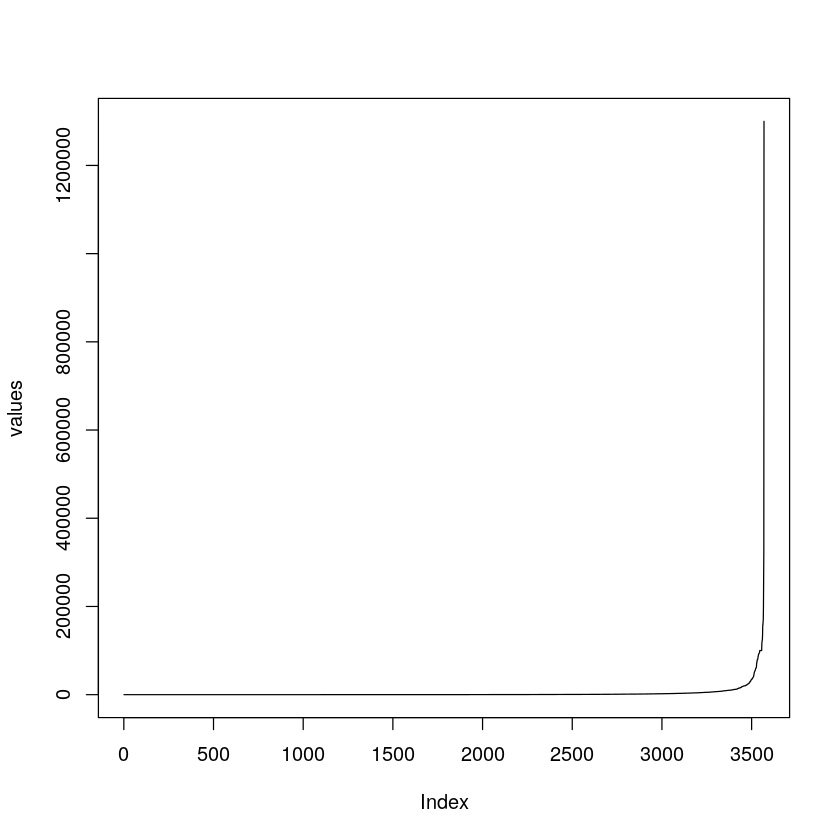

In [7]:
#Comprobemos la distribucion de los valores de IC50
values=sort(medicamentos$value)
plot(values,type="l")
options(repr.plot.width=4, repr.plot.height=4)

In [8]:
#Decidimos un punto de separacion entre valores IC50 altos (HIGH) y bajos (LOW)

median(values)
#Debido a la distribución de los datos la mediana no es fiable, ya que los valores se mantienen bajos
#hasta llegar al último 10% de los datos

[1] 94

In [9]:
#La media se ajusta un poco más
mean(values)

[1] 3368,056

In [10]:
#También se puede escojer como punto de separación, el punto medio de la curva de crecimiento que se ve en
#la gráfica. La posición 3500 (aprox)
values[3500]

[1] 34000

In [11]:
#Obtenemos los SMILES y calculamos los descriptores
#smiles <- medicamentos$smiles
#vectorDescriptores <- data.frame()
#library(rcdk)
#for(i in 1:length(smiles)) {
#  anle138b = parse.smiles(as.vector(smiles[i]))
#  descriptors = get.desc.names(type="all")
#  descriptorsvalues = eval.desc(anle138b,descriptors)
#  vectorDescriptores <- rbind(vectorDescriptores,descriptorsvalues)
#}

In [100]:
#cargamos descriptores moleculares
vectorDescriptores <- read.csv("vectorDescriptores.csv")

#eliminamos columnas con valores constantes (también se eliminan las columnas de NA's)
vectorDescriptores <- remove_constant(vectorDescriptores, na.rm=FALSE)


#eliminamos filas con valores nulos (10); también se eliminan esas mismas filas en medicamentos
medicamentos <- medicamentos[complete.cases(vectorDescriptores),]
vectorDescriptores <- vectorDescriptores[complete.cases(vectorDescriptores),]
                             
#eliminamos las columnas con valores 0
vectorDescriptores <- vectorDescriptores[, colSums(vectorDescriptores != 0) > 0]
                             
#normalizamos y escalamos los datos para que todos estén en el rango (-1,1)
min_max_norm <- function(vec) {
    #para evitar integer overflow:
    if(any(abs(vec) > 100000000)){
        vec <- unlist(lapply(vec,function(x) x<-x/1000))
    }
    mx=max(vec)
    mn=min(vec)
    unlist(lapply(as.numeric(vec),function(x) x=2*(x - mn)/(mx - mn)-1))
}

#lapply(vector, function)

for(attr in names(vectorDescriptores)){
    if(attr!="CanonicalSmiles"){
        vectorDescriptores[[attr]] <- min_max_norm(unlist(vectorDescriptores[[attr]]))  
    }
}

vectorDescriptores

,CanonicalSmiles,nSmallRings,nAromRings,nRingBlocks,nAromBlocks,nRings3,nRings4,nRings5,nRings6,nRings7,...,ATSc4,ATSc5,nAtom,nAromBond,naAromAtom,apol,ALogP,ALogp2,AMR,nAcid
1,Cc1ccccc1C(=O)c2ccc(Nc3ccccc3N)cc2,"-0,50","-0,2","-0,2","-0,2",-1,-1,"-1,0","-0,3333333",-1,...,"-0,3315999","-0,05683787","-0,57575758","-0,16129032","-0,16129032","-0,59252869","-0,069665650","-0,7007742","-0,5846800",-1
2,CCCn1c(SC)nc(c2ccc(F)cc2)c1c3ccncc3,"-0,50","-0,2","-0,2","-0,2",-1,-1,"-0,5","-0,6666667",-1,...,"-0,4167999","-0,08045747","-0,57575758","-0,22580645","-0,22580645","-0,58890996","-0,233522535","-0,8284604","-0,6069521",-1
3,COc1ccc(N2C(=O)Nc3c2ncnc3c4ccccc4C)c(OC)c1,"-0,25","0,2","-0,2","-0,2",-1,-1,"-0,5","-0,3333333",-1,...,"-0,4599157","-0,12822855","-0,49494949","0,09677419","0,03225806","-0,53395143","-0,070950525","-0,7019128","-0,5626445",-1
4,Cc1ccc(cc1)n2nc(cc2NC(=O)Nc3ccc(OCCN4CCOCC4)c5ccccc35)C(C)(C)C,"0,00","0,2","0,2","-0,2",-1,-1,"-0,5","0,0000000",-1,...,"-0,1404514","-0,16308095","0,13131313","0,09677419","0,03225806","-0,02380161","0,154933356","-0,4684102","-0,1367783",-1
5,C[C@H](Nc1nccc(n1)C2=C(C(=O)N3CCCN23)c4ccc(F)cc4)C5CCCCC5,"0,00","-0,2","0,2","-0,2",-1,-1,"0,0","-0,3333333",-1,...,"-0,3304988","-0,26973549","-0,21212121","-0,22580645","-0,22580645","-0,32204881","-0,491387100","-0,9579268","-0,4750692",-1
6,Cc1ccccc1C(=O)c2ccc(Nc3ccccc3N)cc2Cl,"-0,50","-0,2","-0,2","-0,2",-1,-1,"-1,0","-0,3333333",-1,...,"-0,3987504","0,03817243","-0,57575758","-0,16129032","-0,16129032","-0,56922703","0,024144358","-0,6117852","-0,5469156",-1
7,COC1=C[C@]23CCCN2CCc4cc5OCOc5cc4[C@@H]3[C@@H]1O,"0,00","-1,0","-1,0","-1,0",-1,-1,"0,5","-1,0000000",1,...,"-0,3310897","0,33611049","-0,51515152","-0,93548387","-0,93548387","-0,59581821","-0,611642946","-0,9884172","-0,6712949",-1
8,CN(C)c1ccc2c(c3ccncc3)c([nH]c2n1)c4ccc(F)cc4,"-0,25","0,2","-0,2","-0,2",-1,-1,"-0,5","-0,3333333",-1,...,"-0,4518866","0,09158747","-0,55555556","0,09677419","0,03225806","-0,57269177","-0,161004744","-0,7763041","-0,5588176",-1
9,CSc1ccc(CSc2ncc(c3ccc(F)cc3)c(n2)c4ccncc4)cc1,"-0,25","0,2","0,2","0,2",-1,-1,"-1,0","0,0000000",-1,...,"-0,4410799","-0,06426792","-0,45454545","0,22580645","0,22580645","-0,40874331","0,051804473","-0,5833382","-0,3800971",-1
10,Fc1ccc(cc1)c2nc3SCCn3c2c4ccncc4,"-0,25","-0,2","-0,2","-0,2",-1,-1,"0,0","-0,6666667",-1,...,"-0,3940404","-0,08925479","-0,73737374","-0,22580645","-0,22580645","-0,70472105","-0,212908054","-0,8143373","-0,6839364",-1


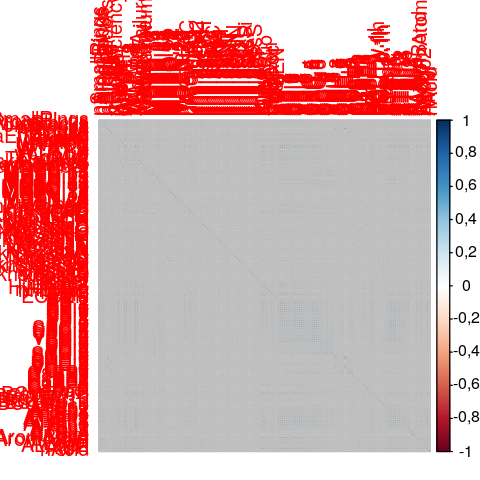

In [13]:
#utilizamos un valor teorico como umbral para definir las clases IC50LOW (1) e IC50HIGH (0)
valorTeorico = 100 # <101 lo consideraremos IC50bajo
vectorClase <- ifelse(medicamentos$value < valorTeorico, 1, 0)
#vectorDescriptores$class <- vectorClase

smiles=vectorDescriptores$CanonicalSmiles
vectorDescriptores$CanonicalSmiles <- NULL
#vectorDescriptores$ic50 <- min_max_norm(medicamentos$value)

#eliminamos las columnas que tienen una alta correlación
correlationMatrix <- cor(vectorDescriptores)
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff = 0.75)

#plot(correlationMatrix[,"ic50"])
corrplot(correlationMatrix)

#vectorDescriptores$ic50 <- NULL

nSmallRings,nAromRings,nRingBlocks,nRings4,nRings6,nRings7,tpsaEfficiency,XLogP,LipinskiFailures,nRotB,...,BCUTc.1h,BCUTp.1l,BCUTp.1h,nBase,ATSm1,ATSc2,ATSc3,ATSc4,ATSc5,nAcid
"-0,50","-0,2","-0,2",-1,"-0,3333333",-1,"-0,4253837","-0,078859620","-1,0000000","-0,6923077",...,"-0,5995475","0,360477297","-0,4947742","-1,0000000","-0,9259588","0,89941718","0,06161071","-0,3315999","-0,05683787",-1
"-0,50","-0,2","-0,2",-1,"-0,6666667",-1,"-0,4710728","0,007335779","-1,0000000","-0,6153846",...,"-0,8136696","-0,353775486","0,3652026","-1,0000000","-0,8827362","0,64522487","0,25170185","-0,4167999","-0,08045747",-1
"-0,25","0,2","-0,2",-1,"-0,3333333",-1,"-0,3070373","-0,330443481","-1,0000000","-0,6923077",...,"-0,1388161","-0,008206504","-0,1446295","-1,0000000","-0,8884056","0,06095565","0,43282464","-0,4599157","-0,12822855",-1
"0,00","0,2","0,2",-1,"0,0000000",-1,"-0,5495563","0,038846282","-0,3333333","-0,2307692",...,"-0,1765186","0,208736521","-0,2136529","-0,3333333","-0,8143644","0,22903974","-0,00814630","-0,1404514","-0,16308095",-1


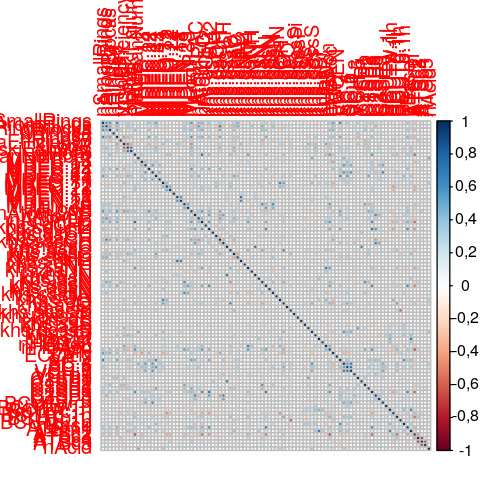

In [14]:
vectorDescriptores <- vectorDescriptores[,-highlyCorrelated]
correlationMatrix <- cor(vectorDescriptores)
corrplot(correlationMatrix)

#vectorDescriptores<- vectorDescriptores[,"khs.ddsN"]
head(vectorDescriptores,4)

## KNN

In [69]:
#Clasificacion para KNN
n = 10 #número de modelos para hacer la media
precisionMedia = 0
sensibilidadMedia = 0
especifidadMedia = 0
exactitudMedia = 0
#k-fold
folds=createFolds(vectorClase,k=n)
for(i in 1:n) {
    #version cutre de división de grupos
    #nEntrenamiento = round(0.8 * nrow(vectorDescriptores))
    #entrenamiento<-sample(1:nrow(vectorDescriptores),nEntrenamiento)
    entrenamiento<-unlist(folds[i])
    conjunto_entrenamiento<-vectorDescriptores[-entrenamiento,]
    conjunto_test<-vectorDescriptores[entrenamiento,]

    y = vectorClase[-entrenamiento]
    #Clasificacion para knn
    prediccionTest <- knn(conjunto_entrenamiento,conjunto_test,cl=factor(y),k=7, l=0, prob=FALSE, use.all=TRUE)
    #vectorDescriptores$class <- vectorClase
    #Obtenemos las clases de los datos de entrenamiento
    validacionTest <- vectorClase[entrenamiento]
    confmatrix <- caret::confusionMatrix(table(prediccionTest, validacionTest))
    precisionMedia = precisionMedia + confmatrix$overall[1]
    sensibilidadMedia = sensibilidadMedia + confmatrix$byClass[1]
    especifidadMedia = especifidadMedia + confmatrix$byClass[2]
    exactitudMedia = exactitudMedia + confmatrix$byClass[5]
}
confmatrix
round((precisionMedia/n),3) #precisión
round((sensibilidadMedia/n),3) #sensibilidad
round((especifidadMedia/n),3) #especifidad
round((exactitudMedia/n),3) #exactitud


Confusion Matrix and Statistics

              validacionTest
prediccionTest   0   1
             0 145  30
             1  41 140
                                          
               Accuracy : 0,8006          
                 95% CI : (0,7552, 0,8408)
    No Information Rate : 0,5225          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0,6014          
                                          
 Mcnemar's Test P-Value : 0,2353          
                                          
            Sensitivity : 0,7796          
            Specificity : 0,8235          
         Pos Pred Value : 0,8286          
         Neg Pred Value : 0,7735          
             Prevalence : 0,5225          
         Detection Rate : 0,4073          
   Detection Prevalence : 0,4916          
      Balanced Accuracy : 0,8015          
                                          
       'Positive' Class : 0               
         

Accuracy 
   0,796

Sensitivity 
      0,774

Specificity 
      0,818

Precision 
    0,804

## Random Forest

In [68]:
#Clasificacion para random forest
n = 10 #número de modelos para hacer la media
precisionMedia = 0
sensibilidadMedia = 0
especifidadMedia = 0
exactitudMedia = 0
#k-fold
folds=createFolds(vectorClase,k=n)
for(i in 1:n) {
    #version cutre de división de grupos
    #nEntrenamiento = round(0.8 * nrow(vectorDescriptores))
    #entrenamiento<-sample(1:nrow(vectorDescriptores),nEntrenamiento)
    entrenamiento<-unlist(folds[i])
    conjunto_entrenamiento<-vectorDescriptores[-entrenamiento,]
    conjunto_test<-vectorDescriptores[entrenamiento,]

    y = as.factor(vectorClase[-entrenamiento])
    #Clasificacion para random forest
    conjunto_entrenamiento$clase <- y
    modeloRF <- randomForest(clase ~ . , data = conjunto_entrenamiento, mtry=9)
    prediccionTest <- predict(modeloRF, conjunto_test, type = "class") 
    #Obtenemos las clases de los datos de entrenamiento
    validacionTest <- vectorClase[entrenamiento]
    #caret::confusionMatrix(predicho, valoresReales)
    #tabla <- table(predicho, validacionTest)
    #tabla
    confmatrix <- caret::confusionMatrix(table(prediccionTest, validacionTest))
    precisionMedia = precisionMedia + confmatrix$overall[1]
    sensibilidadMedia = sensibilidadMedia + confmatrix$byClass[1]
    especifidadMedia = especifidadMedia + confmatrix$byClass[2]
    exactitudMedia = exactitudMedia + confmatrix$byClass[5]
}
confmatrix
round((precisionMedia/n),3) #precisión
round((sensibilidadMedia/n),3) #sensibilidad
round((especifidadMedia/n),3) #especifidad
round((exactitudMedia/n),3) #exactitud

Confusion Matrix and Statistics

              validacionTest
prediccionTest   0   1
             0 143  31
             1  42 140
                                          
               Accuracy : 0,7949          
                 95% CI : (0,7492, 0,8357)
    No Information Rate : 0,5197          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0,5902          
                                          
 Mcnemar's Test P-Value : 0,2418          
                                          
            Sensitivity : 0,7730          
            Specificity : 0,8187          
         Pos Pred Value : 0,8218          
         Neg Pred Value : 0,7692          
             Prevalence : 0,5197          
         Detection Rate : 0,4017          
   Detection Prevalence : 0,4888          
      Balanced Accuracy : 0,7958          
                                          
       'Positive' Class : 0               
         

Accuracy 
   0,809

Sensitivity 
       0,79

Specificity 
      0,828

Precision 
    0,816

In [97]:
#install.packages("pROC")
#install.packages("ROCR")
#library(ROCR)
#library(pROC)
df_prediccionTest <- as.data.frame(prediccionTest)
#roc_obj <- roc(df_prediccionTest)

nrow(conjunto_entrenamiento)
nrow(conjunto_test)



[1] 3203

[1] 356

## Support Vector Machine (SVM)

In [99]:
#Clasificacion para SVM
n = 10 #número de modelos para hacer la media
precisionMedia = 0
sensibilidadMedia = 0
especifidadMedia = 0
exactitudMedia = 0
#k-fold
folds=createFolds(vectorClase,k=n)
for(i in 1:n) {
    #version cutre de división de grupos
    #nEntrenamiento = round(0.8 * nrow(vectorDescriptores))
    #entrenamiento<-sample(1:nrow(vectorDescriptores),nEntrenamiento)
    entrenamiento<-unlist(folds[i])
    conjunto_entrenamiento<-vectorDescriptores[-entrenamiento,]
    conjunto_test<-vectorDescriptores[entrenamiento,]
    
    y = as.factor(vectorClase[-entrenamiento])
    #Clasificacion para random forest
    conjunto_entrenamiento$clase <- y
    suppressWarnings(modeloSVM <- svm(clase ~ . , data = conjunto_entrenamiento, type = "C-classification", kernel = "polynomial",degree = 5, gamma = 0.25))
    prediccionTest <- predict(modeloSVM, conjunto_test, type = "class") 
    #Obtenemos las clases de los datos de entrenamiento
    validacionTest <- vectorClase[entrenamiento]
    #caret::confusionMatrix(predicho, valoresReales)
    #tabla <- table(predicho, validacionTest)
    #tabla
    confmatrix <- caret::confusionMatrix(table(prediccionTest, validacionTest))
    precisionMedia = precisionMedia + confmatrix$overall[1]
    sensibilidadMedia = sensibilidadMedia + confmatrix$byClass[1]
    especifidadMedia = especifidadMedia + confmatrix$byClass[2]
    exactitudMedia = exactitudMedia + confmatrix$byClass[5]
}
confmatrix
round((precisionMedia/n),3) #precisión
round((sensibilidadMedia/n),3) #sensibilidad
round((especifidadMedia/n),3) #especifidad
round((exactitudMedia/n),3) #exactitud

Confusion Matrix and Statistics

              validacionTest
prediccionTest   0   1
             0 130  34
             1  62 130
                                         
               Accuracy : 0,7303         
                 95% CI : (0,681, 0,7758)
    No Information Rate : 0,5393         
    P-Value [Acc > NIR] : 1,026e-13      
                                         
                  Kappa : 0,464          
                                         
 Mcnemar's Test P-Value : 0,005857       
                                         
            Sensitivity : 0,6771         
            Specificity : 0,7927         
         Pos Pred Value : 0,7927         
         Neg Pred Value : 0,6771         
             Prevalence : 0,5393         
         Detection Rate : 0,3652         
   Detection Prevalence : 0,4607         
      Balanced Accuracy : 0,7349         
                                         
       'Positive' Class : 0              
                             

Accuracy 
    0,78

Sensitivity 
      0,772

Specificity 
      0,789

Precision 
     0,78

## Regresión Logística

In [71]:
#Clasificacion para regresión logística
n = 10 #número de modelos para hacer la media
precisionMedia = 0
sensibilidadMedia = 0
especifidadMedia = 0
exactitudMedia = 0
#k-fold
folds=createFolds(vectorClase,k=n)
for(i in 1:n) {
    entrenamiento<-unlist(folds[i])
    conjunto_entrenamiento<-vectorDescriptores[-entrenamiento,]
    conjunto_test<-vectorDescriptores[entrenamiento,]
    y = vectorClase[-entrenamiento]
    #Clasificacion para regresión logística
    conjunto_entrenamiento$clase <- y
    suppressWarnings(modelo <- glm(conjunto_entrenamiento$clase ~ .,
                family = binomial(logit), data=conjunto_entrenamiento))
    suppressWarnings(prediccionTest<-predict(modelo, conjunto_test, type="response"))
    prediccionTest <- ifelse(prediccionTest > 0.5, 1, 0)
    #vectorDescriptores$class <- vectorClase
    #Obtenemos las clases de los datos de entrenamiento
    validacionTest <- vectorClase[entrenamiento]
    confmatrix <- caret::confusionMatrix(table(prediccionTest, validacionTest))
    precisionMedia = precisionMedia + confmatrix$overall[1]
    sensibilidadMedia = sensibilidadMedia + confmatrix$byClass[1]
    especifidadMedia = especifidadMedia + confmatrix$byClass[2]
    exactitudMedia = exactitudMedia + confmatrix$byClass[5]
}
confmatrix
round((precisionMedia/n),3) #precisión
round((sensibilidadMedia/n),3) #sensibilidad
round((especifidadMedia/n),3) #especifidad
round((exactitudMedia/n),3) #exactitud

Confusion Matrix and Statistics

              validacionTest
prediccionTest   0   1
             0 133  36
             1  41 146
                                          
               Accuracy : 0,7837          
                 95% CI : (0,7373, 0,8254)
    No Information Rate : 0,5112          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0,5669          
                                          
 Mcnemar's Test P-Value : 0,6485          
                                          
            Sensitivity : 0,7644          
            Specificity : 0,8022          
         Pos Pred Value : 0,7870          
         Neg Pred Value : 0,7807          
             Prevalence : 0,4888          
         Detection Rate : 0,3736          
   Detection Prevalence : 0,4747          
      Balanced Accuracy : 0,7833          
                                          
       'Positive' Class : 0               
         

Accuracy 
   0,742

Sensitivity 
       0,74

Specificity 
      0,746

Precision 
    0,738

## Comparación

| Comparación |  Precision|Sensibilidad|Especificidad|Exactitud|
|-|-|-|-|-|
| RL  | x|x|x|x|
|  KNN  | x|x|x|x|
|  RF  | x|x|x|x|
|  SVM  | x|x|x|x|